‐ distribution du poids des arêtes# PLDAC Modele de notebook pour proteine LARGE

## Initialisation

In [58]:
# !apt-get install -y pkg-config

In [59]:
# !pip3 install --upgrade pip

# !pip install -q igraph

# #octobre 2023
# !pip install -q pyspark==3.5.0

# !pip install -q pyarrow==4

# erreur?
# !pip install pycairo

affichage convivial des resultats d'une requete

In [60]:
pip install -q itables

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [61]:
!pip install --upgrade pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 39.1 MB/s eta 0:00:0000:0100:01m
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 3.0.0
    Uninstalling pyarrow-3.0.0:
      Successfully uninstalled pyarrow-3.0.0


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from datetime import datetime
from datetime import date
from datetime import timedelta

# pour le chronomètre
import time

# for rmtree
import shutil


import igraph as ig

import networkx as nx



In [63]:

# from google.colab import data_table
# def display1(df, n=100):
#   return data_table.DataTable(pd.DataFrame(df.head(n), columns = df.columns), include_index=False, num_rows_per_page=10)



def display(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return pd.DataFrame(df.head(n), columns = df.columns)
  # return df.limit(n).toPandas()

print("display redéfini")

display redéfini



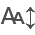

In [64]:
# pour améliorer l'affichage des tableaux contenant le resultat d'une requete
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [65]:
!find /root -name "pyspark" |grep bin

/root/anaconda3/lib/python3.9/site-packages/pyspark/bin/pyspark
/root/anaconda3/pkgs/pyspark-3.1.2-pyhd3eb1b0_0/site-packages/pyspark/bin/pyspark
/root/anaconda3/bin/pyspark


In [66]:
!which java

/usr/bin/java


In [67]:
!java -version

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-post-Debian-1deb10u1)
OpenJDK 64-Bit Server VM (build 11.0.14+9-post-Debian-1deb10u1, mixed mode, sharing)


In [68]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

In [69]:
 # set java.io.tmpdir DOES NOT WORK
# os.environ["java.io.tmpdir"] ="/data/bd/tmp"

### Start spark 

In [70]:
import findspark 
print("findspark.init() initialise les variables d'environnement pour spark") 
findspark.init() 

from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# import pyspark functions
import pyspark.sql.functions as f

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType
from pyspark.sql.functions import col, udf, countDistinct


findspark.init() initialise les variables d'environnement pour spark


In [71]:
def demarrer_spark():
    
  # 60 cores 
  NB_CORES = 60
  # NB_CORES = 64
  local = f"local[{NB_CORES}]"
  # local = "local[*]"
    

  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  
    
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark

spark = demarrer_spark()

# ignorer les warnings

shuffle 180
session démarrée, son id est  local-1713597582114


In [72]:
!ls /data/bd/dataset/proteine/80_80/G99

component_0	     graph_deduplicated_v2	  graph_with_components
component_9	     graph_nodeID_only		  node_with_comp_and_annotation
components.parquet   graph_partition_by_query_id  TEST_RACHA_CALCUL_COMPOSANTES
graph		     graph_removed
graph_deduplicated2  graph_v2


In [73]:
G99 = "/data/bd/dataset/proteine/80_80/G99/"
nodes = spark.read.format("parquet").load(G99 + "graph_with_components") 

In [74]:
display(nodes)

query_id    target_id  component_id  query_length  target_length  \
0   100003172:0  143094166:3         23086            89            799   
1   100003668:0   48815973:0           354           102            222   
2   100004301:0  106189136:2             0           169            695   
3   100004301:0  117840121:3             0           169            264   
4   100004301:0   44038038:1             0           169            524   
5   100004301:0   49847952:5             0           169            458   
6   100004301:0   68146322:0             0           169            509   
7   100004301:0   91784634:5             0           169            532   
8    10000486:1   40045340:2             0            77             84   
9   100005477:3    1061792:3           354            83            295   
10  100005477:3   46123706:0           354            83            215   
11  100007146:0  110429047:0             0            89            153   
12  100007146:0   12065225:3             0            89            324   
13  100007146:0  125644689:2             0            89            264   
14  100007146:0  125759723:0             0            89            219   
15  100007146:0  136141594:0             0            89            202   
16  100007146:0  139761590:0             0            89            154   
17  100007146:0  152563487:0             0            89            237   
18  100007146:0   16942694:2             0            89            249   
19  100007146:0   21547212:2             0            89            199   

    match_length  percent_identity       e_value  relative_sim  r  
0             89             100.0  2.200000e-46         1.000  1  
1            102              99.0  3.900000e-55         0.990  1  
2            169              99.4  3.900000e-94         0.994  1  
3            169             100.0  1.900000e-94         1.000  1  
4            169             100.0  5.400000e-94         1.000  1  
5            169              99.4  1.200000e-93         0.994  1  
6            169              99.4  3.600000e-94         0.994  1  
7            169              99.4  2.200000e-94         0.994  1  
8             77             100.0  1.100000e-28         1.000  1  
9             83             100.0  2.300000e-42         1.000  1  
10            83             100.0  6.900000e-42         1.000  1  
11            89             100.0  1.200000e-41         1.000  1  
12            89             100.0  1.200000e-41         1.000  1  
13            89             100.0  1.300000e-41         1.000  1  
14            89             100.0  1.300000e-41         1.000  1  
15            89             100.0  1.300000e-41         1.000  1  
16            89             100.0  1.300000e-41         1.000  1  
17            89             100.0  1.600000e-41         1.000  1  
18            89             100.0  3.700000e-41         1.000  1  
19            89             100.0  3.700000e-41         1.000  1

In [11]:
# TEST :
 
graph_edges = nodes.select("query_id","target_id","relative_sim")
edges_8 = nodes.filter((nodes["query_id"]=="101017938:0") | ( nodes["target_id"]=="101017938:0"))

display(edges_8)

query_id                          target_id  \
0                        101017938:0   METdb_00312-1-DN8592-c0-g1-i1.p1   
1   METdb_00312-1-DN8592-c0-g1-i1.p1                        101017938:0   
2                        101017938:0  METdb_00308-1-Transcript-23943.p1   
3                         17703062:0                        101017938:0   
4   METdb_00312-1-DN8592-c0-g1-i2.p1                        101017938:0   
5  METdb_00308-1-Transcript-23943.p1                        101017938:0   
6                        101017938:0   METdb_00312-1-DN8592-c0-g1-i2.p1   
7                        101017938:0                         17703062:0   

   component_id  query_length  target_length  match_length  percent_identity  \
0         65954           115            325           115              99.1   
1         65954           325            115           115              99.1   
2         65954           115            233           115             100.0   
3         65954           300            115           115             100.0   
4         65954           399            115           115              99.1   
5         65954           233            115           115             100.0   
6         65954           115            399           115              99.1   
7         65954           115            300           115             100.0   

        e_value  relative_sim  r  
0  1.000000e-56         0.991  1  
1  2.100000e-56         0.991  1  
2  3.600000e-57         1.000  1  
3  5.200000e-57         1.000  1  
4  2.600000e-56         0.991  1  
5  4.000000e-57         1.000  1  
6  1.000000e-56         0.991  1  
7  8.000000e-57         1.000  1

In [75]:
graph = spark.read.format("parquet").load(G99 + "node_with_comp_and_annotation") 
display(graph)

seq_id  component_id  pfamAcc
0   100006141:2       2069752     None
1   100009131:3       4951345  PF00448
2    10001054:1           271  PF02786
3    10001082:0       1849121  PF07714
4   100013718:0             0  PF00125
5    10001645:0       6858176     None
6   100018302:1          2042     None
7   100018755:4        301942  PF00096
8   100019211:5         11908     None
9   100021938:1             0  PF00022
10   10002477:5       6178576     None
11  100025259:3             0  PF14560
12  100025259:3             0  PF11976
13  100025259:3             0  PF00240
14  100027308:0         57215  PF04810
15  100027308:0         57215  PF04811
16  100029418:3         11635  PF00876
17  100034302:1        118168  PF00096
18  100035032:0          8597  PF00060
19  100036266:0       3109589  PF00153

## Regroupement par id de composante :
pour chaque composante on lui associe la liste des sedId et pfamAcc qui lui appartiennent.

In [15]:

from pyspark.sql.functions import *

group_per_component=graph.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
group_per_component.show(20)

+------------+--------------------+--------------------+
|component_id|              seq_id|             pfamAcc|
+------------+--------------------+--------------------+
|         163|[134364368:1, 138...|                  []|
|         303|[35097830:0, 3162...|                  []|
|         549|[11970898:3, 1788...|[PF04990, PF04990...|
|         650|[EukProt-v2_CAMPE...|                  []|
|         852|[EukProt-v2_NP_97...|                  []|
|         870|[EukProt-v2_TRINI...|  [PF05285, PF05285]|
|         906|[METdb_00151-1-DN...|  [PF02204, PF02204]|
|        1119|[METdb_00122-1-DN...|                  []|
|        1131|[METdb_00129-1-DN...|                  []|
|        1185|[METdb_00137-1-DN...|                  []|
|        1188|[METdb_00154-1-DN...|  [PF13516, PF13516]|
|        1606|[METdb_00328-1-DN...|           [PF11211]|
|        1658|[METdb_00344-1-Tr...|                  []|
|        1697|[METdb_00398-1-Tr...|                  []|
|        1779|[METdb_00221-1-DN

## Calcul des homogénéités :
*   Effectuer le calcul des homogénéités fonctionnelles pour chaque composante afin de déterminer si chaque composante ne possède aucune annotation, et le cas échéant, combien d'annotations différentes elle contient.
*   Formule : nb annoatations différentes / nb noeuds annotés

In [16]:

def calculate_size(text):
    return len(set(text))

calculate_size_udf = f.udf(lambda x: calculate_size(x), IntegerType())

# Apply the UDF

group_per_component_3 = group_per_component.withColumn("Indice_homogénéités", calculate_size_udf(f.col("pfamAcc")) / calculate_size_udf(f.col("seq_id"))) \
    .withColumn("Nb_annotation_diff", calculate_size_udf(f.col("pfamAcc"))) \
    .withColumn("Nb_noeuds", calculate_size_udf(f.col("seq_id")))\
    .withColumn("Nb_annotation_total",  size("pfamAcc") )

group_per_component_3.show(10)


+------------+--------------------+--------------------+--------------------+------------------+---------+-------------------+
|component_id|              seq_id|             pfamAcc| Indice_homogénéités|Nb_annotation_diff|Nb_noeuds|Nb_annotation_total|
+------------+--------------------+--------------------+--------------------+------------------+---------+-------------------+
|         163|[134364368:1, 138...|                  []|                 0.0|                 0|        2|                  0|
|         303|[35097830:0, 3162...|                  []|                 0.0|                 0|        2|                  0|
|         549|[11970898:3, 1788...|[PF04990, PF04990...|0.011644832605531296|                 8|      687|               1035|
|         650|[EukProt-v2_CAMPE...|                  []|                 0.0|                 0|        4|                  0|
|         852|[EukProt-v2_NP_97...|                  []|                 0.0|                 0|        2|     

Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/root/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


## Récuperation du nombre de seq annotées :

In [17]:
group_seq_annotees = graph.filter(graph["pfamAcc"]!= 'None')

group_seq_annotees_per_component=group_seq_annotees.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))

group_seq_annotees_per_component_count = group_seq_annotees_per_component.withColumn("Nb_noeuds_annotes", calculate_size_udf(f.col("seq_id"))) \
    .withColumn("Nb_noeuds_annotes_tot", size(f.col("seq_id"))) \
    .withColumn("Nb_annotation_diff",  calculate_size_udf("pfamAcc") )\
    .withColumn("Nb_annotation_total",  size("pfamAcc") )

group_seq_annotees_per_component_count.show(10)


+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|component_id|              seq_id|             pfamAcc|Nb_noeuds_annotes|Nb_noeuds_annotes_tot|Nb_annotation_diff|Nb_annotation_total|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|         549|[11970898:3, 1788...|[PF04990, PF04990...|              575|                 1035|                 8|               1035|
|         870|[97298611:1, 9389...|  [PF05285, PF05285]|                2|                    2|                 1|                  2|
|         906|[65857324:1, 1459...|  [PF02204, PF02204]|                2|                    2|                 1|                  2|
|        1188|[145873867:3, 108...|  [PF13516, PF13516]|                2|                    2|                 1|                  2|
|        1606|         [5173700:2]|           [P

In [171]:
group_seq_annotees_per_component_count.filter(group_seq_annotees_per_component_count["component_id"]==10249).show()

+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|component_id|              seq_id|             pfamAcc|Nb_noeuds_annotes|Nb_noeuds_annotes_tot|Nb_annotation_diff|Nb_annotation_total|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+
|       10249|[99263308:0, 9926...|[PF13561, PF00106...|                5|                   10|                 2|                 10|
+------------+--------------------+--------------------+-----------------+---------------------+------------------+-------------------+



In [107]:
jointure_df = group_seq_annotees_per_component_count.select("component_id","Nb_noeuds_annotes").join(group_per_component_3.select("component_id","Nb_noeuds"), "component_id", "inner")
jointure_df.show(20)


+------------+-----------------+---------+
|component_id|Nb_noeuds_annotes|Nb_noeuds|
+------------+-----------------+---------+
|         650|                1|      464|
|         852|                2|       89|
|         906|                1|       15|
|        1188|                1|        3|
|        1697|                1|       46|
|        2326|                1|        5|
|        4959|              196|      196|
|        5794|                2|       37|
|        7117|                4|        5|
|        7348|                2|        4|
|        8040|                5|       94|
|        8637|               25|       67|
|        8888|               17|       23|
|        9974|                5|       69|
|       10249|                5|        8|
|       10289|               27|       60|
|       10642|                2|        8|
|       11405|               50|       78|
|       11712|                1|       17|
|       12871|                2|        2|
+----------

In [131]:
jointure_df.orderBy(f.col("Nb_noeuds_annotes").desc()).show(20)

+------------+-----------------+---------+
|component_id|Nb_noeuds_annotes|Nb_noeuds|
+------------+-----------------+---------+
|           0|          1131494|  1351764|
|           9|            41609|    45517|
|          17|            33650|    42311|
|         751|            12185|    13568|
|          54|            11823|    13567|
|         425|            11006|    11699|
|           2|             8419|     9171|
|         383|             7916|     8760|
|         220|             7551|    10602|
|         119|             6774|     7654|
|         327|             6674|     7350|
|         752|             6646|     7732|
|        9282|             6340|     7669|
|        2757|             5847|     6148|
|          38|             5539|     6019|
|          11|             5504|     6059|
|         136|             5355|     5891|
|          48|             5319|     6499|
|         298|             5314|     5705|
|        6698|             5159|     5502|
+----------

In [108]:
jointure_df.count()# nombre d ecomposantes comporant des noedus annotés

1639295

In [109]:
group_per_component_3.count() #Nombre de composantes total

10734801

IOPub data rate exceeded.                                                       
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



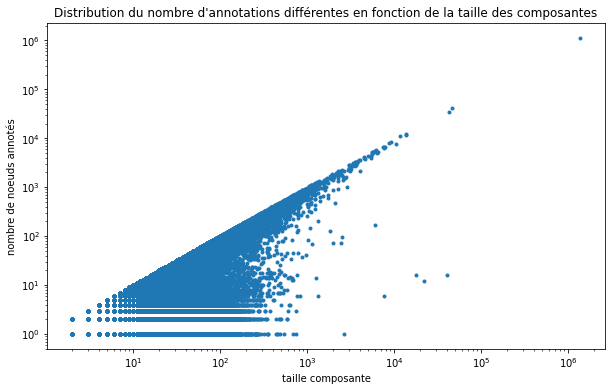

In [119]:
unique_sizes, counts = jointure_df.select("Nb_noeuds").rdd.map(lambda x: x[0]).collect(),jointure_df.select("Nb_noeuds_annotes").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes
plt.figure(figsize=(10,6))

plt.plot(unique_sizes, counts, marker='.', linestyle='none')

plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('taille composante')
plt.ylabel('nombre de noeuds annotés')
plt.title('Distribution du nombre d\'annotations différentes en fonction de la taille des composantes')

plt.show()

In [127]:
nb_annot_possible_per_taille = jointure_df.groupBy("Nb_noeuds").agg(collect_list(col("Nb_noeuds_annotes")).alias("Nb_noeuds_annotes"))
nb_annot_possible_per_taille.show(20)

+---------+--------------------+
|Nb_noeuds|   Nb_noeuds_annotes|
+---------+--------------------+
|      748|               [641]|
|      411|  [338, 9, 163, 390]|
|     4613|              [3835]|
|      473|               [394]|
|      779|          [442, 237]|
|      783|          [598, 608]|
|      471|          [292, 277]|
|      612|               [465]|
|      537|          [393, 475]|
|      960|                [42]|
|       54|[3, 2, 52, 53, 1,...|
|      105|[5, 105, 6, 35, 2...|
|      165|[114, 119, 112, 6...|
|       99|[2, 1, 1, 28, 54,...|
|      173|[10, 173, 82, 5, ...|
|      301|[289, 101, 169, 2...|
|      243|[202, 9, 218, 215...|
|      743|               [647]|
|       58|[13, 2, 30, 37, 3...|
|       77|[46, 64, 42, 65, ...|
+---------+--------------------+
only showing top 20 rows



In [120]:
noeud_annote_per_taille = jointure_df.groupBy("Nb_noeuds").agg(avg("Nb_noeuds_annotes").alias("avg_noeuds_annotes"))
noeud_annote_per_taille.show()


+---------+------------------+
|Nb_noeuds|avg_noeuds_annotes|
+---------+------------------+
|      748|             641.0|
|      411|             225.0|
|     4613|            3835.0|
|      473|             394.0|
|      779|             339.5|
|      783|             603.0|
|      471|             284.5|
|      612|             465.0|
|      537|             434.0|
|      960|              42.0|
|       54| 23.24590163934426|
|      105|           54.8125|
|      165| 85.52173913043478|
|       99|              45.2|
|      173| 94.57142857142857|
|      301|             189.0|
|      243|128.21428571428572|
|      743|             647.0|
|       58|25.972868217054263|
|       77| 35.73154362416108|
+---------+------------------+
only showing top 20 rows



## Affichage d'une composante donnée : 
Ici le group_per_component contient pour chaque composante la liste de ses seqId et pfammAcc .

In [ ]:
def afficher_composante(num_comosante,graph): 
    group_per_component=graph.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
    
    graph_edges = nodes.select("query_id","target_id","relative_sim")
    
    vertices = group_per_component.filter( group_per_component["component_id"]==num_composante)
    
    # Convertir les valeurs de seq_id en une liste Python
    seq_ids_list = [row.seq_id for row in vertices.select("seq_id").distinct().collect()][0]
    # Filtrer les arêtes du graphe en fonction de ces valeurs
    edges = graph_edges.filter((graph_edges["query_id"].isin(seq_ids_list)) &( graph_edges["target_id"].isin(seq_ids_list)))
    
    group_seq_annotees = graph.filter(graph["pfamAcc"]!= 'None')

    group_seq_annotees_per_component=group_seq_annotees.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
    
    #Affichage : 
    # Créer un graphe NetworkX
    G = nx.Graph()

    # Ajouter les arêtes au graphe
    for edge in edges.select("query_id", "target_id").collect():
        source, target = edge
        G.add_edge(source, target)


    # Liste de nœuds avec couleurs spécifiques pour chaque groupe
    les_annotations = group_seq_annotees_per_component.filter(group_seq_annotees_per_component["component_id"]==num_composante).select("pfamAcc").distinct().collect()
    les_annotations = np.unique(les_annotations[0].pfamAcc)


    nodes_annote = group_seq_annotees_per_component.filter(group_seq_annotees_per_component["component_id"]==num_composante)
    nodes_annote = np.unique([row.seq_id for row in nodes_annote.select("seq_id").distinct().collect()][0])
    print(nodes_annote)

    les_annotations_bis = graph.filter(graph["seq_id"].isin( list(nodes_annote))).select("seq_id","pfamAcc").distinct().collect()

    result = list(set(seq_ids_list) - set(nodes_annote))
    # Ajouter des nœuds rouges au graphe
    for node in nodes_annote:
        G.add_node(node, color='red')

    # Ajouter des nœuds bleus au graphe
    for node in result:
        G.add_node(node, color='blue')

    # Dessiner le graphe avec les couleurs spécifiées
    colors = [G.nodes[node]['color'] for node in G.nodes]
    plt.figure(figsize=(10, 8))
    plt.legend(labels=[f"{label}" for label in les_annotations], loc="upper left")

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, edge_color='black', linewidths=1, font_size=12)
    plt.title("Graphe avec des nœuds annotés rouges  et pas annotés bleus  "+"\n Les annotations ditinctes présentes dans cette composnates sont : "+", ".join(les_annotations))


Exécution étape par étape et explication : 

In [76]:
group_per_component=graph.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
group_per_component.show(20)

+------------+--------------------+--------------------+
|component_id|              seq_id|             pfamAcc|
+------------+--------------------+--------------------+
|         163|[134364368:1, 138...|                  []|
|         303|[35097830:0, 3162...|                  []|
|         549|[11970898:3, 1788...|[PF04990, PF04990...|
|         650|[EukProt-v2_CAMPE...|                  []|
|         852|[EukProt-v2_NP_97...|                  []|
|         870|[EukProt-v2_TRINI...|  [PF05285, PF05285]|
|         906|[METdb_00151-1-DN...|  [PF02204, PF02204]|
|        1119|[METdb_00122-1-DN...|                  []|
|        1131|[METdb_00129-1-DN...|                  []|
|        1185|[METdb_00137-1-DN...|                  []|
|        1188|[METdb_00154-1-DN...|  [PF13516, PF13516]|
|        1606|[METdb_00328-1-DN...|           [PF11211]|
|        1658|[METdb_00344-1-Tr...|                  []|
|        1697|[METdb_00398-1-Tr...|                  []|
|        1779|[METdb_00221-1-DN

Ici on récupère les arrêtes ainsi que le degré de similarité entre les noeuds qui les composent .

In [78]:
 
graph_edges = nodes.select("query_id","target_id","relative_sim")
display(graph_edges)


query_id    target_id  relative_sim
0   100003172:0  143094166:3         1.000
1   100003668:0   48815973:0         0.990
2   100004301:0  106189136:2         0.994
3   100004301:0  117840121:3         1.000
4   100004301:0   44038038:1         1.000
5   100004301:0   49847952:5         0.994
6   100004301:0   68146322:0         0.994
7   100004301:0   91784634:5         0.994
8    10000486:1   40045340:2         1.000
9   100005477:3    1061792:3         1.000
10  100005477:3   46123706:0         1.000
11  100007146:0  110429047:0         1.000
12  100007146:0   12065225:3         1.000
13  100007146:0  125644689:2         1.000
14  100007146:0  125759723:0         1.000
15  100007146:0  136141594:0         1.000
16  100007146:0  139761590:0         1.000
17  100007146:0  152563487:0         1.000
18  100007146:0   16942694:2         1.000
19  100007146:0   21547212:2         1.000

On récupère les informations relative a la composante a afficher (La liste de ses noeuds pfamAcc etc ....)

In [105]:
# Recuprer les arrete d'une composante : 
num_composante = 870
vertices = group_per_component.filter( group_per_component["component_id"]==num_composante)

vertices.show() 

+------------+--------------------+------------------+
|component_id|              seq_id|           pfamAcc|
+------------+--------------------+------------------+
|         870|[EukProt-v2_TRINI...|[PF05285, PF05285]|
+------------+--------------------+------------------+



On recupere pour les noeud de cette composantes les arêtes qui les relient 

In [106]:

# Convertir les valeurs de seq_id en une liste Python
seq_ids_list = [row.seq_id for row in vertices.select("seq_id").distinct().collect()][0]
print(seq_ids_list)
# Filtrer les arêtes du graphe en fonction de ces valeurs
edges = graph_edges.filter((graph_edges["query_id"].isin(seq_ids_list)) &( graph_edges["target_id"].isin(seq_ids_list)))
edges.show()


['EukProt-v2_TRINITY_DN28914_c0_g1_i8.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i16.p1', '97298611:1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i15.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i10.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i23.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i20.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i26.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i6.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i1.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i19.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i27.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i3.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i11.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i4.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i5.p1', 'EukProt-v2_TRINITY_DN28914_c0_g1_i7.p1', '93897605:0']


+--------------------+--------------------+------------+
|            query_id|           target_id|relative_sim|
+--------------------+--------------------+------------+
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v2_TRINIT...|         1.0|
|EukProt-v2_TRINIT...|EukProt-v

In [98]:
seq_ids_list

['EukProt-v2_CAMPEP_0168571514',
 'METdb_00170-1-Transcript-29333.p1',
 'METdb_00170-1-Transcript-29334.p1',
 'EukProt-v2_CAMPEP_0168541832']

Permet de récuperer les seqId annotés seulement afin de pourvoir les afficher avec une couleur diffèrente

In [107]:
group_seq_annotees = graph.filter(graph["pfamAcc"]!= 'None')

group_seq_annotees_per_component=group_seq_annotees.groupBy(col("component_id")).agg(collect_list(col("seq_id")).alias("seq_id"),collect_list(col("pfamAcc")).alias("pfamAcc"))
group_seq_annotees_per_component.show(10)


+------------+--------------------+--------------------+
|component_id|              seq_id|             pfamAcc|
+------------+--------------------+--------------------+
|         549|[11970898:3, 1788...|[PF04990, PF04990...|
|         870|[97298611:1, 9389...|  [PF05285, PF05285]|
|         906|[65857324:1, 1459...|  [PF02204, PF02204]|
|        1188|[145873867:3, 108...|  [PF13516, PF13516]|
|        1606|         [5173700:2]|           [PF11211]|
|        2196|[11240518:4, 1161...|[PF00227, PF00227...|
|        2305|[10239360:3, 1105...|[PF06068, PF06068...|
|        2326|[77508684:1, 7750...|[PF17207, PF07726...|
|        2529|[103183320:0, 121...|[PF00285, PF00285...|
|        3127|[146008917:0, 147...|[PF10230, PF10230...|
+------------+--------------------+--------------------+
only showing top 10 rows



['93897605:0' '97298611:1']
[Row(seq_id='97298611:1', pfamAcc='PF05285'), Row(seq_id='93897605:0', pfamAcc='PF05285')]


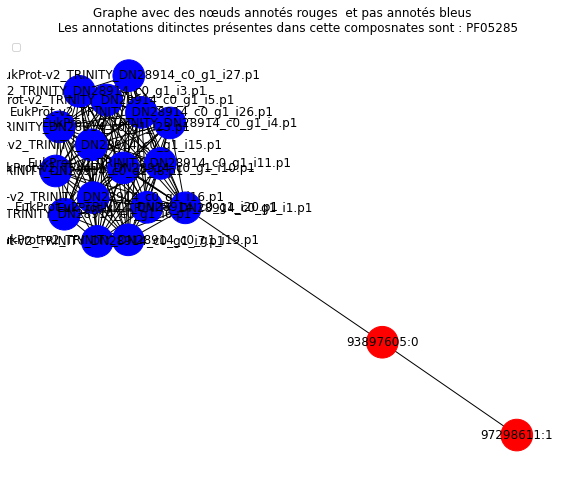

In [110]:

# Créer un graphe NetworkX
G = nx.Graph()

# Ajouter les arêtes au graphe
for edge in edges.select("query_id", "target_id").collect():
    source, target = edge
    G.add_edge(source, target)


# Liste de nœuds avec couleurs spécifiques pour chaque groupe
les_annotations = group_seq_annotees_per_component.filter(group_seq_annotees_per_component["component_id"]==num_composante).select("pfamAcc").distinct().collect()
les_annotations = np.unique(les_annotations[0].pfamAcc)


nodes_annote = group_seq_annotees_per_component.filter(group_seq_annotees_per_component["component_id"]==num_composante)
nodes_annote = np.unique([row.seq_id for row in nodes_annote.select("seq_id").distinct().collect()][0])
print(nodes_annote)

les_annotations_bis = graph.filter(graph["seq_id"].isin( list(nodes_annote))).select("seq_id","pfamAcc").distinct().collect()
print(les_annotations_bis)

result = list(set(seq_ids_list) - set(nodes_annote))
# Ajouter des nœuds rouges au graphe
for node in nodes_annote:
    G.add_node(node, color='red')

# Ajouter des nœuds bleus au graphe
for node in result:
    G.add_node(node, color='blue')

# Dessiner le graphe avec les couleurs spécifiées
colors = [G.nodes[node]['color'] for node in G.nodes]
plt.figure(figsize=(10, 8))
plt.legend(labels=[f"{label}" for label in les_annotations], loc="upper left")

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, edge_color='black', linewidths=1, font_size=12)
plt.title("Graphe avec des nœuds annotés rouges  et pas annotés bleus  "+"\n Les annotations ditinctes présentes dans cette composnates sont : "+", ".join(les_annotations))
plt.show()

## Regroupement par nombre d'annotations différentes :

In [112]:
group_bn_annot_diff = group_per_component_3.groupBy(col("Nb_annotation_diff")).count()
group_bn_annot_diff.show(10)

+------------------+-----+
|Nb_annotation_diff|count|
+------------------+-----+
|                54|    1|
|                21|    8|
|                23|    7|
|                 9| 1090|
|                25|    6|
|                42|    2|
|                15|   50|
|                 7| 4722|
|                16|   28|
|                27|    4|
+------------------+-----+
only showing top 10 rows



## Regroupement par nombre d'annotations total: :

In [113]:
group_bn_annot_total = group_per_component_3.groupBy(col("Nb_annotation_total")).count()
group_bn_annot_total.show(10)

+-------------------+-----+
|Nb_annotation_total|count|
+-------------------+-----+
|                411|    3|
|                603|    1|
|                473|    1|
|                471|    4|
|                748|    1|
|                307|    3|
|                612|    2|
|                660|    1|
|                537|    2|
|                783|    2|
+-------------------+-----+
only showing top 10 rows



In [114]:
filtered_df_1 = group_bn_annot_diff.filter(group_bn_annot_diff["Nb_annotation_diff"] == 1)
filtered_df_0 = group_bn_annot_total.filter(group_bn_annot_total["Nb_annotation_total"] == 0)

filtered_df_1 = filtered_df_1.first()
filtered_df_1 = filtered_df_1["count"]

filtered_df_0 = filtered_df_0.first()
filtered_df_0 = filtered_df_0["count"]

print("Le nombre de composantes ayant qu'une seule annotation est de :" , filtered_df_1)
print("Le nombre de composantes n'ayant aucune annotation est de :" , filtered_df_0)


Le nombre de composantes ayant qu'une seule annotation est de : 844457
Le nombre de composantes n'ayant aucune annotation est de : 5712806


## Fréquence des Indice d'homogénéités :

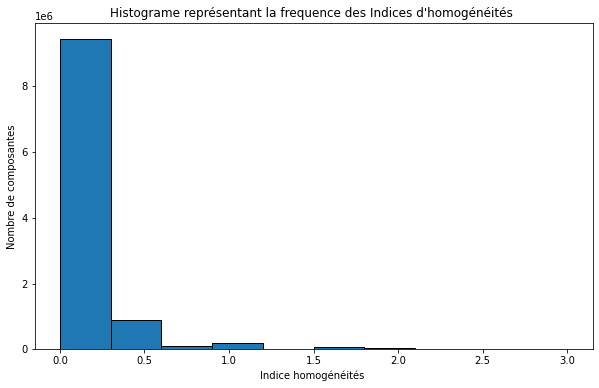

In [246]:

import matplotlib.pyplot as plt
# Filtrer les valeurs où "Indice_homogénéités" est inférieur ou égal à 5
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 3)

# Collecter les résultats
count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
#count_values = group_per_component_3.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(count_values, bins=10, edgecolor='black')
plt.xlabel('Indice homogénéités ')
plt.ylabel('Nombre de composantes')
plt.title('Histograme représentant la frequence des Indices d\'homogénéités ')
plt.show()


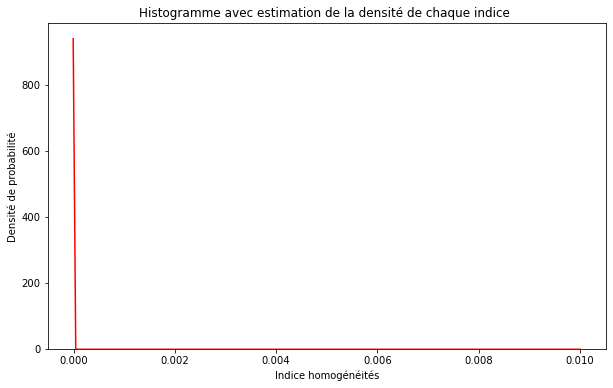

In [248]:


# Collecte des valeurs de l'indice d'homogénéité
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 0.01)

count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
# Définition des labels et du titre
plt.figure(figsize=(10,6))
# Tracer l'estimation de la densité du noyau (KDE)
sns.kdeplot(count_values, color='r')



plt.xlabel('Indice homogénéités')
plt.ylabel('Densité de probabilité')
plt.title('Histogramme avec estimation de la densité de chaque indice ')

# Affichage du graphique
plt.show()

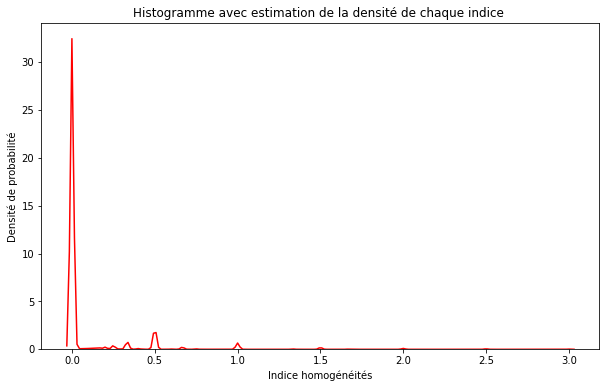

In [253]:


# Collecte des valeurs de l'indice d'homogénéité
filtered_df = group_per_component_3.filter(group_per_component_3["Indice_homogénéités"] <= 3)

count_values = filtered_df.select("Indice_homogénéités").rdd.map(lambda x: x[0]).collect()
# Définition des labels et du titre
plt.figure(figsize=(10,6))
# Tracer l'estimation de la densité du noyau (KDE)
sns.kdeplot(count_values, color='r')



plt.xlabel('Indice homogénéités')
plt.ylabel('Densité de probabilité')
plt.title('Histogramme avec estimation de la densité de chaque indice ')

# Affichage du graphique
plt.show()

## Fréquence du nombre d'annotations différentes :

[54, 58, 21, 23, 9, 92, 25, 42, 15, 7, 16, 27, 49, 14, 6, 19, 32, 56, 30, 31, 52, 17, 18, 40, 28, 24, 62, 44, 55, 11, 50, 22, 34, 10, 38, 57, 29, 8, 37, 48, 5, 20, 47, 41, 46, 39, 13, 26, 4, 59, 1, 33, 12, 0, 3, 2, 2115, 43]
[2, 2, 10, 10, 1275, 1, 6, 2, 54, 5809, 30, 4, 1, 88, 13837, 12, 4, 1, 2, 3, 3, 20, 23, 2, 3, 4, 1, 1, 1, 350, 1, 9, 3, 608, 1, 1, 5, 2844, 1, 1, 32173, 15, 2, 3, 2, 2, 133, 5, 51928, 1, 1087851, 3, 220, 9095506, 114577, 327343, 1, 1]


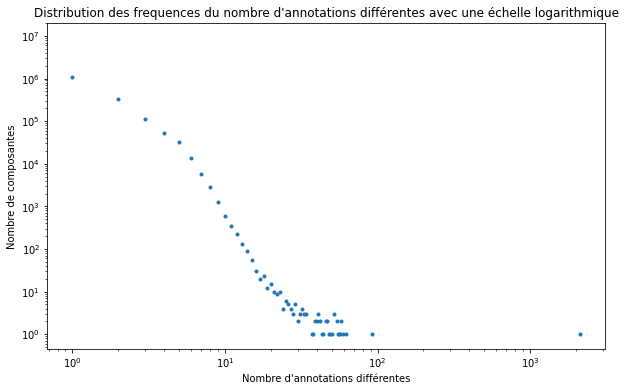

In [295]:
import numpy as np

unique_sizes, counts = group_bn_annot_diff.select("Nb_annotation_diff").rdd.map(lambda x: x[0]).collect(),group_bn_annot_diff.select("count").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes
plt.figure(figsize=(10,6))

plt.plot(unique_sizes, counts, marker='.', linestyle='none')
plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'annotations différentes')
plt.ylabel('Nombre de composantes')
plt.title('Distribution des frequences du nombre d\'annotations différentes avec une échelle logarithmique')

plt.show()

In [296]:
print("Size max  : ",np.max(unique_sizes), "avec frequece ",np.min(counts))
print("Frequence max des composantes de tailles petite : ",np.min(unique_sizes)," est de  : ",np.max(counts))

Size max  :  2115 avec frequece  1
Frequence max des composantes de tailles petite :  0  est de  :  9095506


## Fréquence du nombre d'annotations totales :

[748, 537, 471, 603, 307, 612, 660, 473, 783, 960, 411, 105, 54, 165, 173, 99, 1025, 243, 301, 2014, 743, 1038, 58, 77, 516, 2167, 1664, 21, 871, 66, 460, 206, 241, 590, 3176, 930, 83, 383, 1902, 23, 481, 212, 535, 1022, 1730, 866, 1651, 45, 88, 632, 1116, 6674, 561, 926, 345, 1232, 877, 996, 663, 864, 244, 673, 238, 633, 2101, 9, 285, 863, 474, 375, 720, 6492, 3384, 976, 92, 971, 604, 1278, 1013, 240, 2783, 621, 998, 25, 232, 2852, 782, 42, 141, 117, 175, 1222, 337, 899, 1426, 1388, 201, 1197, 334, 1043, 381, 436, 1201, 656, 765, 35, 735, 1412, 479, 1501, 378, 692, 140, 521, 1300, 5487, 15, 152, 250, 617, 310, 478, 377, 731, 315, 239, 2092, 291, 955, 292, 304, 1037, 463, 1590, 606, 623, 651, 8803, 741, 361, 253, 684, 512, 1202, 1270, 100, 489, 1551, 580, 161, 1093, 458, 452, 1283, 770, 1223, 687, 61, 352, 127, 316, 523, 2997, 492, 531, 274, 616, 7, 162, 547, 689, 637, 107, 198, 218, 2231651, 1108, 16, 84, 1520, 551, 1468, 975, 288, 167, 945, 394, 728, 342, 2407, 289, 630, 745, 93, 101

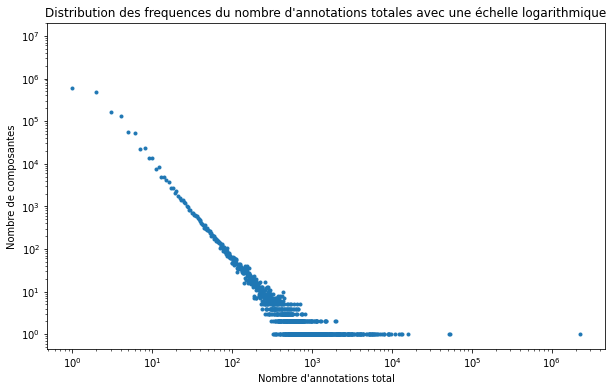

In [293]:
unique_sizes, counts = group_bn_annot_total.select("Nb_annotation_total").rdd.map(lambda x: x[0]).collect(),group_bn_annot_total.select("count").rdd.map(lambda x: x[0]).collect()
print(unique_sizes)
print(counts)
# Tracer la courbe en échelle logarithmique pour les deux axes

plt.figure(figsize=(10,6))
plt.plot(unique_sizes, counts, marker='.', linestyle='none')
plt.xscale('log')
plt.yscale('log')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre d\'annotations total')
plt.ylabel('Nombre de composantes')
plt.title('Distribution des frequences du nombre d\'annotations totales avec une échelle logarithmique')

plt.show()

In [294]:
print("Size max  : ",np.max(unique_sizes), "avec frequece ",np.min(counts))
print("Frequence max des composantes de tailles petite : ",np.min(unique_sizes)," est de  : ",np.max(counts))

Size max  :  2231651 avec frequece  1
Frequence max des composantes de tailles petite :  0  est de  :  9095506


# Homogenité new

In [18]:
graph_annotation = spark.read.format("parquet").load(G99 + "node_with_comp_and_annotation") 
display(graph_annotation)

seq_id  component_id  pfamAcc
0   100006141:2       2069752     None
1   100009131:3       4951345  PF00448
2    10001054:1           271  PF02786
3    10001082:0       1849121  PF07714
4   100013718:0             0  PF00125
5    10001645:0       6858176     None
6   100018302:1          2042     None
7   100018755:4        301942  PF00096
8   100019211:5         11908     None
9   100021938:1             0  PF00022
10   10002477:5       6178576     None
11  100025259:3             0  PF14560
12  100025259:3             0  PF11976
13  100025259:3             0  PF00240
14  100027308:0         57215  PF04810
15  100027308:0         57215  PF04811
16  100029418:3         11635  PF00876
17  100034302:1        118168  PF00096
18  100035032:0          8597  PF00060
19  100036266:0       3109589  PF00153

In [19]:
graph_annotation_filtered = graph_annotation.filter(col("pfamAcc").isNotNull())
display(graph_annotation_filtered)

seq_id  component_id  pfamAcc
0   100009131:3       4951345  PF00448
1    10001054:1           271  PF02786
2    10001082:0       1849121  PF07714
3   100013718:0             0  PF00125
4   100018755:4        301942  PF00096
5   100021938:1             0  PF00022
6   100025259:3             0  PF14560
7   100025259:3             0  PF11976
8   100025259:3             0  PF00240
9   100027308:0         57215  PF04810
10  100027308:0         57215  PF04811
11  100029418:3         11635  PF00876
12  100034302:1        118168  PF00096
13  100035032:0          8597  PF00060
14  100036266:0       3109589  PF00153
15  100040243:5        314678  PF00294
16  100044610:3        742899  PF00917
17  100045530:1             0  PF03953
18  100045571:3       3240750  PF00400
19  100045825:1       2058735  PF02817

In [20]:
graph_annotation_grouped = graph_annotation_filtered.groupBy("seq_id", "component_id") \
                        .agg(collect_set("pfamAcc").alias("pfamAcc_list"))
display(graph_annotation_grouped)

seq_id  component_id  \
0   100021568:0       3441338   
1   100044972:3       1336574   
2   100045942:2        165077   
3   100046653:0         71749   
4   100050598:0             0   
5   100051586:5        306312   
6   100051759:0       1012427   
7   100055100:4       1525937   
8   100055302:2        232754   
9   100056022:1       3392864   
10  100056576:1             0   
11  100056862:1        292050   
12  100057107:2         17048   
13  100058138:1            17   
14  100059322:4             0   
15  100059498:1          5993   
16  100059499:1          5993   
17  100060992:0         50602   
18  100061430:2        126355   
19  100064036:0        384546   

                                              pfamAcc_list  
0                                                [PF05470]  
1                                                [PF00028]  
2   [PF00063, PF00784, PF07653, PF00612, PF14604, PF00018]  
3                                       [PF00573, PF14374]  
4                                                [PF00687]  
5   [PF13895, PF07679, PF13306, PF13855, PF13927, PF00047]  
6            [PF13202, PF13405, PF13499, PF00036, PF13833]  
7                                                [PF00076]  
8                                                [PF01145]  
9            [PF13895, PF07679, PF07686, PF13927, PF00047]  
10                                               [PF16891]  
11                                      [PF01522, PF01607]  
12                                      [PF00025, PF00503]  
13                                               [PF00009]  
14                                               [PF16493]  
15                             [PF01833, PF00612, PF03859]  
16                             [PF01833, PF00612, PF03859]  
17                                               [PF03166]  
18                                               [PF00024]  
19                                               [PF02434]

In [38]:
graph_annotation_size_1 = graph_annotation_grouped.filter(size("pfamAcc_list") == 1).withColumn("pfamAcc_list", expr("pfamAcc_list[0]"))
graph_annotation_size_ge_2 = graph_annotation_grouped.filter(size("pfamAcc_list") >= 2)

In [40]:
graph_annotation_size_1_grouped = graph_annotation_size_1.groupBy("component_id") \
                        .agg(collect_set("pfamAcc_list").alias("pfamAcc_list_1"))
display(graph_annotation_size_1_grouped)

component_id  \
0            549   
1            870   
2            906   
3           1188   
4           1606   
5           2196   
6           2305   
7           2326   
8           2529   
9           3127   
10          4067   
11          4343   
12          5253   
13          5409   
14          5794   
15          6787   
16          7117   
17          7348   
18          8888   
19          9446   

                                                              pfamAcc_list_1  
0   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]  
1                                                                  [PF05285]  
2                                                                  [PF02204]  
3                                                                  [PF13516]  
4                                                                  [PF11211]  
5                                                [PF00004, PF07728, PF00227]  
6                                                                  [PF06068]  
7                                                                  [PF14551]  
8                              [PF00549, PF08442, PF16114, PF02629, PF00285]  
9                                                                  [PF10230]  
10                                                        [PF00152, PF01336]  
11                                                        [PF00344, PF10559]  
12                                                                 [PF14644]  
13                                                                 [PF09815]  
14                                                                 [PF00137]  
15                                                                 [PF00125]  
16                                                                 [PF00454]  
17                                                                 [PF06485]  
18                                               [PF00884, PF07707, PF00651]  
19                                                                 [PF10405]

In [41]:
display(graph_annotation_size_ge_2)

seq_id  component_id  \
0   100045942:2        165077   
1   100046653:0         71749   
2   100051586:5        306312   
3   100051759:0       1012427   
4   100056022:1       3392864   
5   100056862:1        292050   
6   100057107:2         17048   
7   100059498:1          5993   
8   100059499:1          5993   
9   100067305:0       3517782   
10  100067927:3       5026675   
11  100088571:5        972043   
12  100097249:4        180407   
13  100107695:2       3084699   
14  100114275:0           135   
15  100115603:1        867436   
16  100127178:4       4514569   
17  100168511:0           372   
18  100249780:4             0   
19  100280555:2             0   

                                                       pfamAcc_list  
0            [PF00063, PF00784, PF07653, PF00612, PF14604, PF00018]  
1                                                [PF00573, PF14374]  
2            [PF13895, PF07679, PF13306, PF13855, PF13927, PF00047]  
3                     [PF13202, PF13405, PF13499, PF00036, PF13833]  
4                     [PF13895, PF07679, PF07686, PF13927, PF00047]  
5                                                [PF01522, PF01607]  
6                                                [PF00025, PF00503]  
7                                       [PF01833, PF00612, PF03859]  
8                                       [PF01833, PF00612, PF03859]  
9                                                [PF02197, PF00027]  
10                                      [PF00071, PF00025, PF08477]  
11                                      [PF00069, PF00433, PF07714]  
12                                               [PF07647, PF00536]  
13                                      [PF08659, PF00106, PF13561]  
14                                               [PF00467, PF16906]  
15                                               [PF13233, PF05347]  
16                                               [PF08373, PF06743]  
17                                      [PF01370, PF16363, PF04321]  
18                                               [PF05221, PF00670]  
19  [PF12763, PF13202, PF13405, PF13499, PF00036, PF13833, PF08976]

In [43]:

joined_df = graph_annotation_size_1_grouped.join(graph_annotation_size_ge_2, "component_id")
display(joined_df)



component_id  \
0            549   
1            549   
2            549   
3            549   
4            549   
5            549   
6            549   
7            549   
8            549   
9            549   
10           549   
11           549   
12           549   
13           549   
14           549   
15           549   
16           549   
17           549   
18           549   
19           549   

                                                              pfamAcc_list_1  \
0   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
1   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
2   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
3   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
4   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
5   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
6   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
7   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
8   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
9   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
10  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
11  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
12  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
13  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
14  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
15  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
16  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
17  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
18  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
19  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   

         seq_id                                            pfamAcc_list  
0    24370574:3                                      [PF04998, PF04990]  
1    24370576:3                                      [PF04998, PF04990]  
2    53805592:5                                      [PF04998, PF04990]  
3    36565374:0                                      [PF00623, PF04997]  
4    51588156:0                                      [PF04998, PF04990]  
5     7896353:2           [PF05000, PF04992, PF04998, PF04990, PF05001]  
6    98242739:3                             [PF04998, PF04990, PF05001]  
7     7916443:2                                      [PF04998, PF04990]  
8     8043069:4                                      [PF04992, PF04998]  
9     6026854:0                             [PF04992, PF04998, PF04990]  
10    8041674:3                                      [PF04998, PF04990]  
11   24517152:0                                      [PF00623, PF04997]  
12   51062043:1                                      [PF00623, PF04997]  
13   98223140:3                                      [PF00623, PF04983]  
14   53824944:5                                      [PF04998, PF04990]  
15  150004603:1                             [PF04992, PF04998, PF04990]  
16   54297872:2                             [PF04992, PF04998, PF04990]  
17   86961919:1  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04997]  
18   97615256:2                                      [PF00623, PF04997]  
19   40273487:3                                      [PF04998, PF04990]

In [45]:
# Définir une fonction UDF pour la logique de la nouvelle colonne pfamAcc
def select_pfamAcc(pfamAcc_list_df1, pfamAcc_list_df2):
    intersection = set(pfamAcc_list_df1) & set(pfamAcc_list_df2)
    if intersection:
        return list(intersection)[0]
    else:
        return pfamAcc_list_df2[0]

select_pfamAcc_udf = udf(select_pfamAcc, StringType())
# Appliquer la fonction UDF pour créer la nouvelle colonne pfamAcc
result_annotation = joined_df.withColumn("pfamAcc", select_pfamAcc_udf(col("pfamAcc_list_1"), col("pfamAcc_list")))
display(result_annotation)

component_id  \
0            549   
1            549   
2            549   
3            549   
4            549   
5            549   
6            549   
7            549   
8            549   
9            549   
10           549   
11           549   
12           549   
13           549   
14           549   
15           549   
16           549   
17           549   
18           549   
19           549   

                                                              pfamAcc_list_1  \
0   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
1   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
2   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
3   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
4   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
5   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
6   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
7   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
8   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
9   [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
10  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
11  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
12  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
13  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
14  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
15  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
16  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
17  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
18  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   
19  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04990, PF04997, PF05001]   

         seq_id                                            pfamAcc_list  \
0    24370574:3                                      [PF04998, PF04990]   
1    24370576:3                                      [PF04998, PF04990]   
2    53805592:5                                      [PF04998, PF04990]   
3    36565374:0                                      [PF00623, PF04997]   
4    51588156:0                                      [PF04998, PF04990]   
5     7896353:2           [PF05000, PF04992, PF04998, PF04990, PF05001]   
6    98242739:3                             [PF04998, PF04990, PF05001]   
7     7916443:2                                      [PF04998, PF04990]   
8     8043069:4                                      [PF04992, PF04998]   
9     6026854:0                             [PF04992, PF04998, PF04990]   
10    8041674:3                                      [PF04998, PF04990]   
11   24517152:0                                      [PF00623, PF04997]   
12   51062043:1                                      [PF00623, PF04997]   
13   98223140:3                                      [PF00623, PF04983]   
14   53824944:5                                      [PF04998, PF04990]   
15  150004603:1                             [PF04992, PF04998, PF04990]   
16   54297872:2                             [PF04992, PF04998, PF04990]   
17   86961919:1  [PF05000, PF04992, PF04983, PF00623, PF04998, PF04997]   
18   97615256:2                                      [PF00623, PF04997]   
19   40273487:3                                      [PF04998, PF04990]   

    pfamAcc  
0   PF04998  
1   PF04998  
2   PF04998  
3   PF04997  
4   PF04998  
5   PF05000  
6   PF05001  
7   PF04998  
8   PF04998  
9   PF04998  
10  PF04998  
11  PF04997  
12  PF04997  
13  PF04983  
14  PF04998  
15  PF04998  
16  PF04998  
17  PF05000  
18  PF04997  
19  PF04998

In [47]:
result_annotation_filtred = result_annotation.select(col("component_id"), col("seq_id"), col("pfamAcc"))
display(result_annotation_filtred)

component_id       seq_id  pfamAcc
0            549   24370574:3  PF04998
1            549   24370576:3  PF04998
2            549   53805592:5  PF04998
3            549   36565374:0  PF04997
4            549   51588156:0  PF04998
5            549    7896353:2  PF05000
6            549   98242739:3  PF05001
7            549    7916443:2  PF04998
8            549    8043069:4  PF04998
9            549    6026854:0  PF04998
10           549    8041674:3  PF04998
11           549   24517152:0  PF04997
12           549   51062043:1  PF04997
13           549   98223140:3  PF04983
14           549   53824944:5  PF04998
15           549  150004603:1  PF04998
16           549   54297872:2  PF04998
17           549   86961919:1  PF05000
18           549   97615256:2  PF04997
19           549   40273487:3  PF04998

In [54]:
# Calculer le nombre total de nœuds / on peut utiliser aprés le dataframe de size component
total_node_component = graph_annotation.groupBy("component_id").agg(countDistinct("seq_id").alias("seq_id_count"))
display(total_node_component)

component_id  seq_id_count
0           2305          1935
1         454011             2
2        6889832             2
3         110460           795
4        4505043             5
5        4847923             3
6        3953310             2
7        5320472             2
8        1600741             2
9        3366433             2
10        985571            41
11         73850            72
12       3143846             2
13       2716263             2
14       4109182             3
15        317365            12
16       5833499             2
17       1530787            45
18        680223             3
19       2388024             3

In [55]:
distinct_annotations_component = result_annotation_filtred.groupBy("component_id").agg(countDistinct("pfamAcc").alias("distinct_annotations"))
display(distinct_annotations_component)

component_id  distinct_annotations
0        1862340                     1
1        4772720                     1
2         815100                     1
3         959411                     3
4        4305758                     1
5        4368463                     1
6        4561464                     1
7        4847757                     1
8        5912269                     1
9        1700983                     1
10       6938235                     1
11         88910                     1
12        435987                     1
13        595768                     1
14       1655234                     1
15       4136319                     1
16       5819437                     1
17       6498740                     1
18        856727                     1
19       1299077                     1

In [56]:
joined_annotations_component = total_node_component.join(distinct_annotations_component, "component_id")
# Calculer l'indice d'homogénéité pour chaque composant
homogeneity_index_df = joined_annotations_component.withColumn("homogeneity_index", (1 - col("distinct_annotations")) / col("seq_id_count"))

# Afficher le DataFrame résultant
display(homogeneity_index_df)

component_id  seq_id_count  distinct_annotations  homogeneity_index
0            549           687                     6          -0.007278
1           2196           809                     1           0.000000
2           2305          1935                     1           0.000000
3           2326             2                     1           0.000000
4           2529           805                     3          -0.002484
5           4067           236                     1           0.000000
6           4343           150                     1           0.000000
7           8888           196                     4          -0.015306
8          10831           121                     1           0.000000
9          11387            25                     1           0.000000
10         11712             2                     1           0.000000
11         18615            28                     1           0.000000
12         20742           158                     1           0.000000
13         25045            86                     2          -0.011628
14         25278            38                     2          -0.026316
15         28846             6                     1           0.000000
16         36068            16                     1           0.000000
17         38744            12                     1           0.000000
18         38875             4                     1           0.000000
19         40696           221                     4          -0.013575